In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pygsp as pg
from pygsp import plotting
from scipy.linalg import expm

In [3]:
N = 21
G = pg.graphs.Path(N)

Text(0.5, 1.0, 'Signal at time t=0')

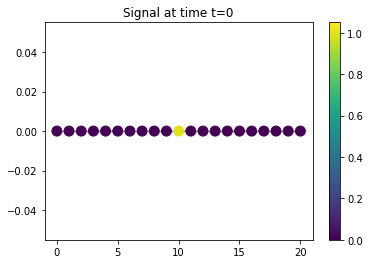

In [4]:
delta_pos = 10
f = np.zeros(N)
f[delta_pos] = 1.0
plotting.plot_signal(G,f)
plt.title("Signal at time t=0")


Text(0.5, 1.0, 'Signal at time t=10')

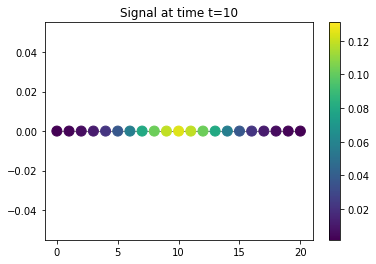

In [5]:
# extract Laplacian and evolve matrix one unit of time, plot result
L = G.L.toarray()
L = L/np.trace(L)*(L.shape[0])
f_evolved = expm(-10*L)@f
plotting.plot_signal(G,f_evolved)
plt.title("Signal at time t=10")


Trying to learn from the diffused signal

In [17]:
import learnHeat as lh
X = f_evolved[:,None]
rg = nx.fast_gnp_random_graph(N, p = 0.4)
L0 = nx.laplacian_matrix(rg).toarray()
L0 = L0/np.trace(L0)*N
tau0 = [1]
D0=lh.D(L0, tau0)


In [18]:
H0 = np.random.rand(D0.shape[1], X.shape[1])

In [ ]:
#result = lh.learn_heat(X = X, 
#                    L0=L0, H0 = H0, tau0=tau0, 
#                    verbose=False, 
#                    max_iter = 50, alpha = 0.1, beta=1)
# division by 0

In [44]:
result = lh.learn_heat(X = X, 
                    L0=L0, H0 = H0, tau0=tau0, 
                    verbose=False, 
                    max_iter = 50, alpha = 0, beta=0)
L_to_save = result["L"]

Learning progress:   0%|          | 0/50 [00:00<?, ?it/s]

In [125]:
from scipy.io import savemat
savemat("matrix_to_plot",{'L_to_save':L_to_save})
savemat("signal_to_plot",{'H_to_save':result["H"]})

In [9]:
result["L"][abs(result["L"])<0.01] = 0
Adj = -np.copy(result["L"])
np.fill_diagonal(Adj, 0)
G_learned = pg.graphs.Graph(Adj)

Text(0.5, 1.0, 'Learned graph and initial signal')

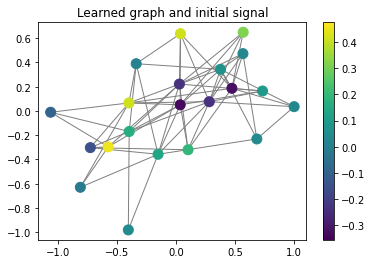

In [10]:
G_learned.set_coordinates()
plotting.plot_signal(G_learned,result["H"])
plt.title("Learned graph and initial signal")

In [12]:
# evolve signal to see what happens
H_evolved = expm(-result["tau"]*result["L"])@result["H"]

Text(0.5, 1.0, 'Learned graph and evolved signal at t=1.5')

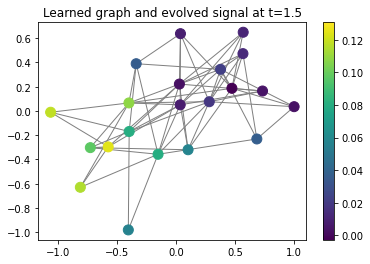

In [13]:
plotting.plot_signal(G_learned,H_evolved)
plt.title("Learned graph and evolved signal at t=1.5")

What happens if I just keep the most weighted edge?

In [54]:
L_learned = np.copy(result["L"])
L_learned[abs(L_learned)<0.01] = 0
L_learned = -L_learned

In [55]:
# do the fucking loop
for i in range(L_learned.shape[0]):
    sorted_arr = sorted(L_learned[i,:], reverse=True) # sort array in descending order
    for j in range(len(sorted_arr)):
        if L_learned[i,j] < sorted_arr[1]:
            L_learned[i,j] = 0

In [57]:
L_one_edge = pg.graphs.Graph(L_learned)

Text(0.5, 1.0, 'Taking the two most weighted edges')

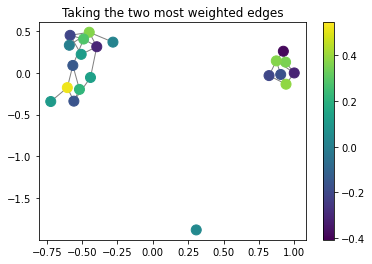

In [58]:
L_one_edge.set_coordinates()
plotting.plot_signal(L_one_edge,result["H"])
plt.title("Taking the two most weighted edges")

Let's try to do the algoritm with $X\in \mathbb{R}^{N\times M}$

In [72]:
tauvec = list(np.linspace(0,10,30))
f = np.reshape(f, (-1, 1))
X_new = np.concatenate([expm(-tau_s*L)@f for tau_s in tauvec],axis=1)

In [81]:
result_new = lh.learn_heat(X_new,L0,H0,[1],0,0)

Learning progress:   0%|          | 0/100 [00:00<?, ?it/s]

In [94]:
def plot_shit_learned(result):
    Adj = -np.copy(result["L"])
    Adj[abs(Adj)<0.03] = 0
    np.fill_diagonal(Adj, 0)
    G_learned = pg.graphs.Graph(Adj)
    G_learned.set_coordinates()
    plotting.plot_signal(G_learned,result["H"][:,0])
    plt.title("Learned graph and initial signal")

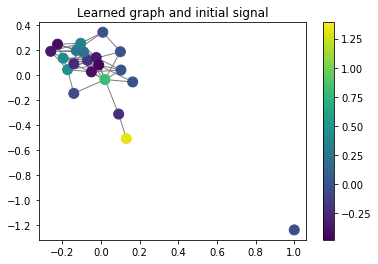

In [95]:
plot_shit_learned(result_new)

In [82]:
def print_shit(result,X,L,H,tau):
    print("Learned")
    print(lh.cal_cost(X,result["L"],result["H"],result["tau"],0,0))
    print("True cost")
    print(lh.cal_cost(X,L,H,tau,0,0))

In [85]:
print_shit(result_new,X_new,L,result_new["H"],result_new["tau"])

Learned
0.01082455868855305
True cost
7.781790824732398
